In [1]:
# Random Imports
import os
import sys
import pathlib
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

# Regular schema dictates that we put DATAPATH
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))
os.environ['WANDB_NOTEBOOK_NAME'] = 'train.ipynb'

from datetime import datetime
# Get today's date
today_date = datetime.now()
# Format the date as MM_DD_YY
formatted_date = today_date.strftime("%m_%d_%y")

# Setup direcrtories
root = pathlib.Path('/storage/vbutoi/scratch/ESE')

%load_ext yamlmagic
%load_ext autoreload
%autoreload 2

## Define said jobs

In [2]:
%%yaml default_cfg 

experiment:
  seed: 42
    
dataloader:
  batch_size: 8 
  num_workers: 1
  pin_memory: True 

optim: 
  _class: torch.optim.Adam
  lr: 3.0e-4
  weight_decay: 0.0 
  
train:
  epochs: 1000 
  eval_freq: 5 
  # pretrained_dir: None # In case we want to load a pretrained model.

log:
  checkpoint_freq: 20 
  root: '?'
  metrics:
    dice_score:
      _fn: ionpy.metrics.dice_score
      from_logits: True
      batch_reduction: 'mean' 
      ignore_empty_labels: False 
      ignore_index: 0 # Ignore background class when reporting.

######################
# Cross-Entropy Loss #
######################
# loss_func: 
#   _class: ionpy.loss.PixelCELoss
#   from_logits: True
#   batch_reduction: 'mean' 
  
#############
# Dice Loss #
#############
loss_func: 
  _class: ionpy.loss.SoftDiceLoss
  from_logits: True
  batch_reduction: 'mean' 
  ignore_empty_labels: False 
  ignore_index: 0 

<IPython.core.display.Javascript object>

In [3]:
%%yaml model_cfg  

model:
  _class: ese.experiment.models.unet.UNet
  filters: [64, 64, 64, 64, 64]
  convs_per_block: 3

<IPython.core.display.Javascript object>

In [4]:
%%yaml dataset_cfg 

########
## WMH #
########
# data:
#   _class: ese.experiment.datasets.WMH
#   axis: 0
#   task: Amsterdam
#   slicing: dense 
#   annotator: observer_o12
#   num_slices: 1
#   in_channels: 1
#   out_channels: 2 
#   version: 0.2
#   iters_per_epoch: 1000 
#   preload: True 

###################
## OASIS 4-Labels #
###################
# data:
#   _class: ese.experiment.datasets.OASIS
#   axis: 0
#   label_set: label4
#   slicing: central 
#   num_slices: 1
#   in_channels: 1
#   out_channels: 5 
#   central_width: 32
#   version: 0.1
#   preload: False 

###################
## OASIS 35-Labels #
###################
data:
  _class: ese.experiment.datasets.OASIS
  axis: 1
  label_set: label35
  num_slices: 1
  in_channels: 1
  central_width: 32
  version: 0.1
  out_channels: '?' 
  binary: '?' 
  target_labels: '?' 
  preload: False 

###############
## CityScapes #
###############
# data:
#   _class: ese.experiment.datasets.CityScapes
#   in_channels: 3
#   out_channels: 35

###############
## OxfordPets #
###############
# data:
#   _class: ese.experiment.datasets.OxfordPets
#   preload: True
#   version: 0.1
#   num_classes: all 
#   in_channels: 3
#   out_channels: 38 # 37 + 1 (background)

######################
## Binary OxfordPets #
######################
# data:
#   _class: ese.experiment.datasets.BinaryPets
#   preload: True
#   version: 0.1
#   in_channels: 3
#   out_channels: 2

<IPython.core.display.Javascript object>

In [5]:
%%yaml lite_aug_cfg

- RandomVariableElasticTransform:
    p: 0.5
    alpha: [1, 2] 
    sigma: [8, 10]
- RandomHorizontalFlip:
    p: 0.5
- RandomVerticalFlip:
    p: 0.5

<IPython.core.display.Javascript object>

In [6]:
%%yaml callbacks_cfg

callbacks:
  step:
    - ese.experiment.callbacks.ShowPredictions
  epoch:
    - ese.experiment.callbacks.WandbLogger
    - ionpy.callbacks.ETA
    - ionpy.callbacks.JobProgress
    - ionpy.callbacks.TerminateOnNaN
    - ionpy.callbacks.PrintLogged
    - ionpy.callbacks.ModelCheckpoint:
        monitor: dice_score
        phase: val

<IPython.core.display.Javascript object>

## Debug Station

In [7]:
# WMH SPECIFIC PARAMS 
# wmh_params = {
#     'log.metrics.dice_score.ignore_empty_labels': [False], # Set False for WMH, True otherwise.
#     'loss_func.ignore_empty_labels': [False], # Set False for WMH, True otherwise. USE FOR DICE
# }


# Setup the root.
exp_name = 'OASIS35_Thalamus_RunSet'
exp_root = str(root / 'training' / formatted_date / exp_name)
# Create the ablation options
option_set = [
    {
        'log.root': [exp_root],
        'data.target_labels': [[7, 26]], # choose only the label corresponding to thalamus.
        'data.out_channels': [2], # 2 classes: thalamus and background.
        'data.binary': [True],
        'data.preload': [False],
        'data.slicing': ['dense'],
        'experiment.seed': [40, 41, 42, 43, 44]
    }
]
# Update with Dataset Specific Parameters
# for option_dict in option_set:
#     option_dict.update(wmh_params)

In [8]:
import copy
from ionpy.util import Config
from ionpy.util.config import check_missing
from ese.scripts.utils import get_option_product

# Assemble base config
base_cfg = Config(default_cfg).update([model_cfg, dataset_cfg, callbacks_cfg])

# Set the augmentation
# light_augmentations = sum([copy.deepcopy(lite_aug_cfg)], start=[])

# Get the configs
raw_cfgs = get_option_product(exp_name, option_set, base_cfg)

cfgs = []
for cfg in raw_cfgs:
    # cfg = cfg.set('augmentations', light_augmentations)
    check_missing(cfg) # Verify there are no ? in config.
    cfgs.append(cfg)

In [9]:
len(cfgs)

5

## Running Jobs

Set seed: 40
Running CalibrationExperiment("/storage/vbutoi/scratch/ESE/training/01_11_24/debug/20240111_105044-WKNI-1998e3e96f63df830149f1efc9964e07")
---
callbacks:
  epoch:
  - ionpy.callbacks.ETA
  - ionpy.callbacks.JobProgress
  - ionpy.callbacks.TerminateOnNaN
  - ionpy.callbacks.PrintLogged
  - ionpy.callbacks.ModelCheckpoint:
      monitor: dice_score
      phase: val
  step:
  - ese.experiment.callbacks.ShowPredictions
data:
  _class: ese.experiment.datasets.OASIS
  axis: 1
  binary: true
  central_width: 32
  label_set: label35
  num_slices: 1
  preload: false
  slicing: dense
  target_labels:
  - 7
  - 26
  version: 0.1
dataloader:
  batch_size: 8
  num_workers: 1
  pin_memory: true
experiment:
  seed: 40
log:
  checkpoint_freq: 20
  metrics:
    dice_score:
      _fn: ionpy.metrics.dice_score
      batch_reduction: mean
      from_logits: true
      ignore_empty_labels: false
      ignore_index: 0
  root: /storage/vbutoi/scratch/ESE/training/01_11_24/debug
  wandb_string: e

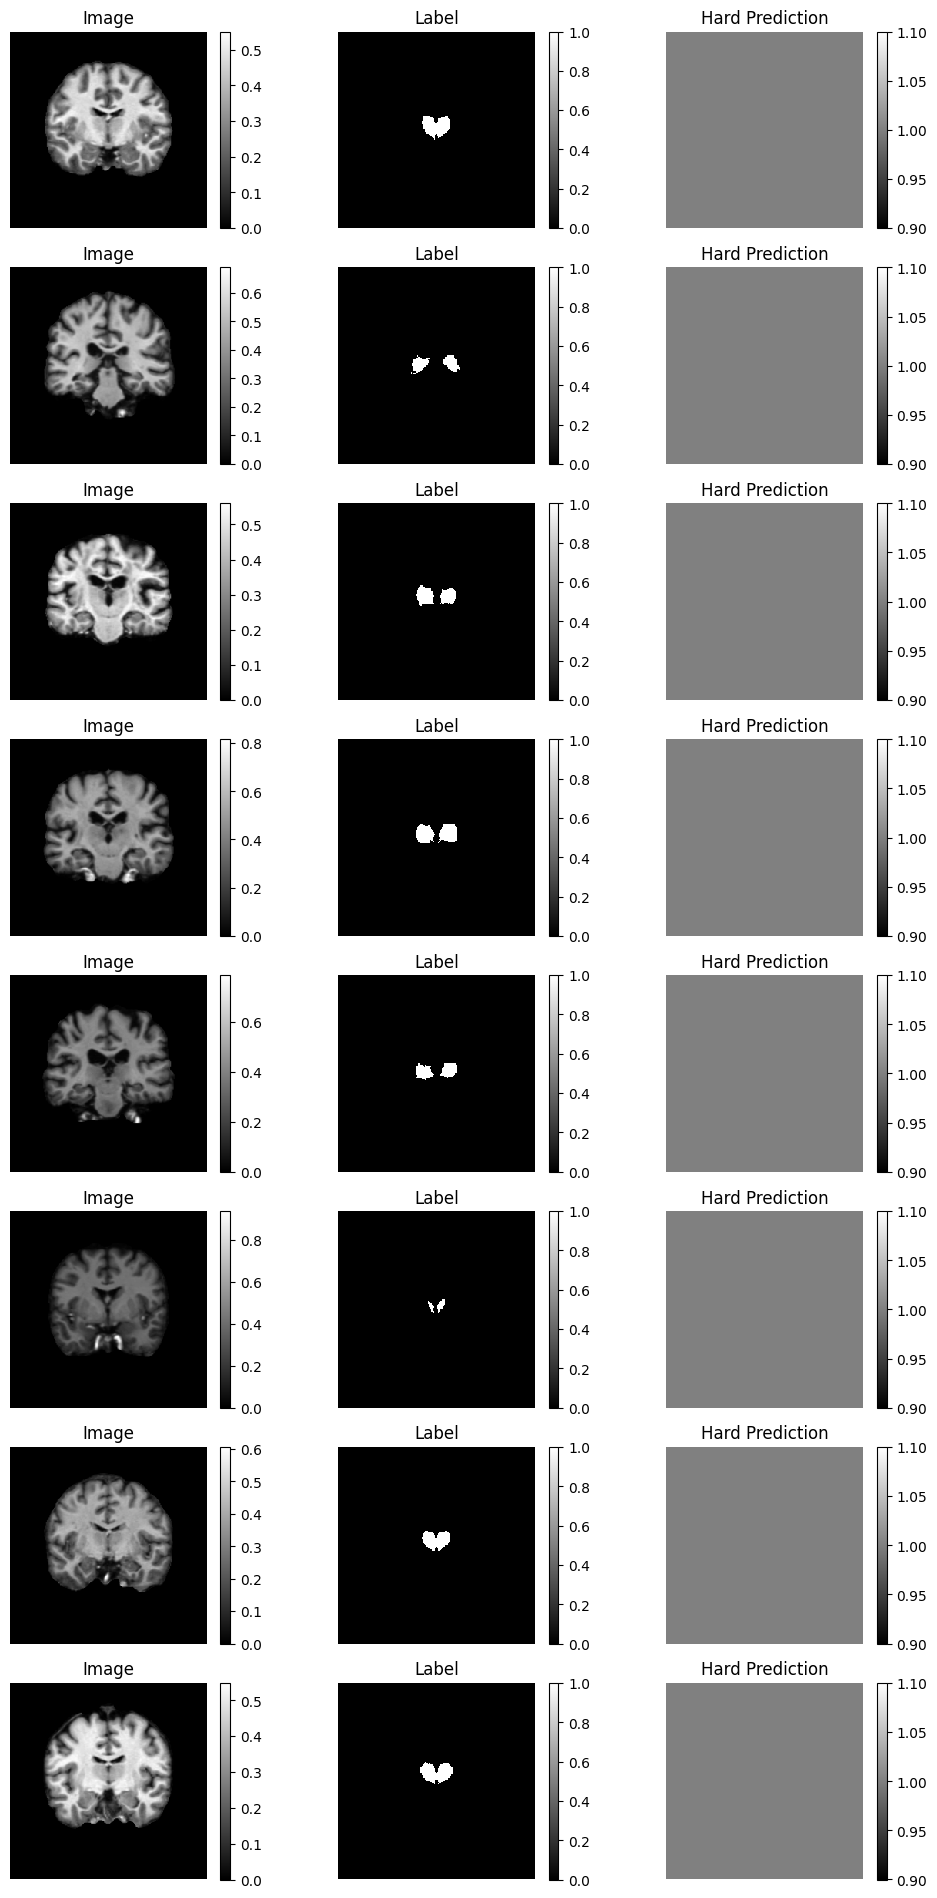

KeyboardInterrupt: 

In [10]:
######## FOR DEBUGGING
from ese.experiment.experiment import run_ese_exp, CalibrationExperiment

run_ese_exp(
    config=cfgs[0], 
    experiment_class=CalibrationExperiment,
    gpu='0',
    run_name='debug',
    show_examples=True,
    track_wandb=False
)

In [ ]:
# # FOR SUBMISSION
# from ese.experiment.experiment import submit_ese_exps, CalibrationExperiment 

# submit_ese_exps(
#     exp_root=exp_root,
#     experiment_class=CalibrationExperiment,
#     config_list=cfgs,
#     available_gpus=['0', '1', '2', '3'],
#     track_wandb=True
# )